In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Mar 20 04:31:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    55W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 16.6 MB/s eta 0:00:00


In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 90.7 MB/s eta 0:00:00


In [5]:
from datasets import load_dataset
import pandas as pd
from datasets import DatasetDict, Dataset
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification
from huggingface_hub import notebook_login
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
# To train on an arm macbook
# device = torch.device("mps" if (torch.backends.mps.is_available() and torch.backends.mps.is_built()) else "cpu")
# To train on cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
%cd /content/drive/MyDrive/CS769/CS769-Project 
# Change to your file path

/content/drive/MyDrive/CS769/CS769-Project


In [32]:
'''
Utility Functions
'''

def pre_process(df):
    # make label id a list
    df["label"] = df.apply(lambda row: [int(label) for label in row["label"].replace(" ", "").split(",")],
                             axis=1)
    # map label id to emotions
    df["emotion"] = df.apply(lambda row: [label_dict[label_id] for 
                                          label_id in row["label"]], 
                             axis=1)
    return df

def show_example(data_dict, split, index):
    example = data_dict[split][index]
    print(example)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(15, 15))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False, xticks_rotation="vertical")
  plt.title("Normalized confusion matrix")
  plt.show()

In [8]:
!ls

 data   distilbert-base-cased-finetuned-emotion  'EDA with Hugging Face.ipynb'


In [9]:
'''
Load Data
'''

file_path = r"data/labels.txt"  # Replace with the path to your text file

with open(file_path, "r", encoding="utf-8") as f:
    labels = f.readlines()

label_dict = {index: label.strip() for index, label in enumerate(labels)}

data_files = {
    "train": "data/tsv_files/train.tsv",
    "validation": "data/tsv_files/dev.tsv",
    "test": "data/tsv_files/test.tsv",
}



dataset_dict = DatasetDict({
    split: Dataset.from_pandas(
        pre_process(
            pd.read_csv(file_path, 
                        header=None, 
                        sep="\t",
                        names=["text", "label", "user_id"])
        )) for split, file_path in data_files.items()
})

dataset_dict.set_format(type="pandas")

In [10]:
# Show example 
split = "test"  # Replace with "validation" or "test" if needed
index = 0         # Replace with the index of the desired example
show_example(dataset_dict, split, index)

                                                text label  user_id    emotion
0  I’m really sorry about your situation :( Altho...  [25]  eecwqtt  [sadness]


### Some Basic Visualizations

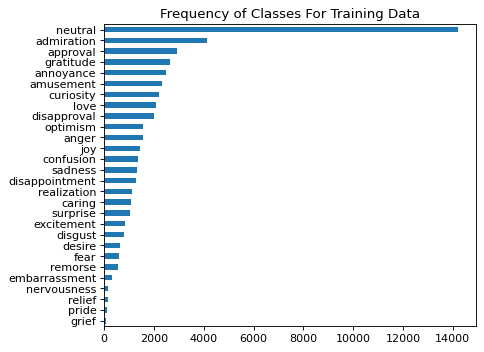

In [11]:
# Visualize Class Distribution
def get_emotion_series(split, data_dict):
    emotions = pd.Series([emotion for emotion_list in data_dict["train"]["emotion"] for emotion in emotion_list])
    return emotions

splits = ['train', 'validation', 'test']

def naive_multilabel_sulotion(df):
    df_naive = df.drop("emotion", axis=1)
    df_naive = df_naive.explode("label")
    df_naive["emotion"] = df_naive.apply(lambda row: label_dict[row["label"]], axis=1)
    return df_naive
    
plt.figure(figsize=(6, 5), dpi=80)
emotions = get_emotion_series("train", dataset_dict)
emotions.value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes For Training Data")
plt.show()

In [12]:
def naive_process():
    dataset_dict_naive = DatasetDict({
        split: Dataset.from_pandas(
            naive_multilabel_sulotion(dataset_dict[split].to_pandas())) for split in splits
    })
    return dataset_dict_naive
dataset_dict_naive = naive_process()

In [13]:
# Show example 
split = "train"  # Replace with "validation" or "test" if needed
index = 0         # Replace with the index of the desired example
show_example(dataset_dict_naive, split, index)

{'text': "My favourite food is anything I didn't have to cook myself.", 'label': 27, 'user_id': 'eebbqej', 'emotion': 'neutral', '__index_level_0__': 0}


<Figure size 900x900 with 0 Axes>

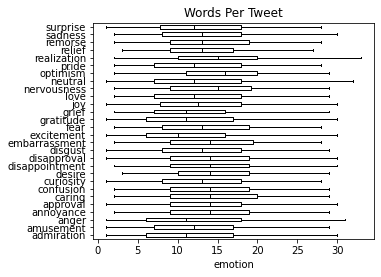

In [14]:
plt.figure(figsize=(9, 9), dpi=100)
df = dataset_dict_naive["train"].to_pandas()
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="emotion", grid=False,
 showfliers=False, color="black", vert=False)
plt.subplots_adjust(left=0.25)
plt.suptitle("")
plt.show()

In [15]:
dataset_dict_naive.reset_format()

### Naive Baseline

In [16]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

print(tokenize(dataset_dict_naive["train"][:2]))

{'input_ids': [[101, 1422, 9122, 2094, 1110, 1625, 146, 1238, 112, 189, 1138, 1106, 9834, 1991, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1986, 1191, 1119, 1674, 1228, 1471, 117, 2490, 1209, 1341, 1119, 1116, 1515, 170, 4046, 13084, 1158, 1114, 1234, 1939, 1104, 2140, 2044, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [17]:
emotions_encoded = dataset_dict_naive.map(tokenize, batched=True, batch_size=None)
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/51103 [00:00<?, ? examples/s]

Map:   0%|          | 0/6380 [00:00<?, ? examples/s]

Map:   0%|          | 0/6329 [00:00<?, ? examples/s]

In [18]:
from transformers import AutoModel
auto_model = AutoModel.from_pretrained(model_ckpt).to(device)

def extract_hidden_states(batch):
  # Place model inputs on the GPU
  inputs = {k:v.to(device) for k,v in batch.items() 
  if k in tokenizer.model_input_names}
  # Extract last hidden states
  with torch.no_grad():
    last_hidden_state = auto_model(**inputs).last_hidden_state
  # Return vector for [CLS] token
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/51103 [00:00<?, ? examples/s]

Map:   0%|          | 0/6380 [00:00<?, ? examples/s]

Map:   0%|          | 0/6329 [00:00<?, ? examples/s]

In [21]:
num_labels = 28
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device)
        )

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)

In [22]:
trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.965000,1.598416,0.530721,0.489300
2,1.547200,1.524740,0.542790,0.514329
3,1.407900,1.499213,0.542320,0.518450
4,1.307400,1.500576,0.543887,0.521771
5,1.241000,1.505332,0.540125,0.522712


In [23]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [24]:
preds_output.metrics

{'test_loss': 1.5053316354751587,
 'test_accuracy': 0.5401253918495298,
 'test_f1': 0.5227122656943745,
 'test_runtime': 2.7072,
 'test_samples_per_second': 2356.698,
 'test_steps_per_second': 36.939}

In [25]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(emotions_hidden["validation"]["label"])

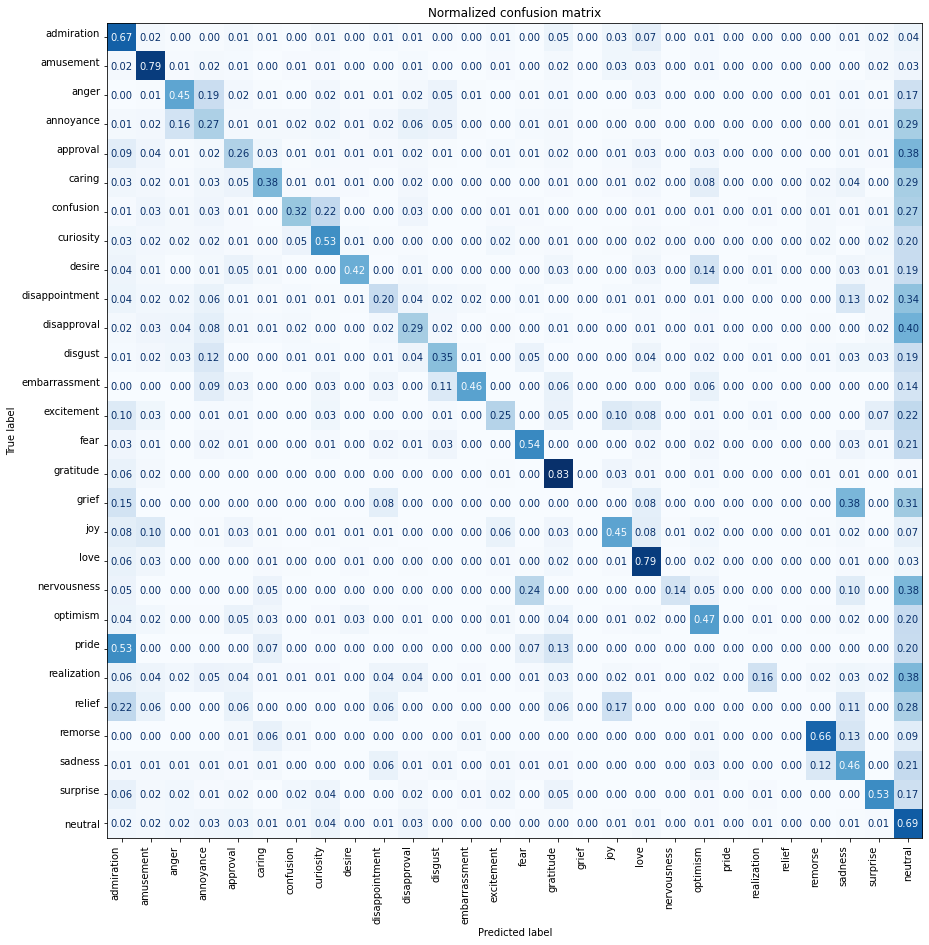

In [33]:
plot_confusion_matrix(y_preds, y_valid, labels)